In [1]:
%load_ext autoreload
%autoreload 2
from lib import rubin
from lib import privacy_accounting
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy.stats as stats
from tqdm import tqdm
import warnings
import functools
import itertools

In [2]:
plt.style.use("default")
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [97]:
figdir = "latex/figures/gaussian-test/"

analyst_label = "Analyst's $p(\mu | X, I_A)$"
data_provider_label = "Data provider's $p(\mu | X, I_S)$"
syn_data_label = "With syn. data $\\bar{p}_n(\mu)$"

analyst_label_sigma2 = "Analyst's $p(\sigma^2 | X, I_A)$"
data_provider_label_sigma2 = "Data provider's $p(\sigma^2 | X, I_S)$"
syn_data_label_sigma2 = "With syn. data $\\bar{p}_n(\sigma^2)$"

np.random.seed(647836826)
mu_true = 1
sigma_true = 2
n = 100
X = np.random.normal(mu_true, sigma_true, n)

In [98]:
def invchisquare(nu, sigma2):
    return stats.invgamma(a=nu / 2, scale=nu * sigma2 / 2)

def known_variance_inference(X, mu_0, sigma_0, known_sigma):
    n = X.size
    X_mean = np.mean(X)
    posterior_mu = (n * 1 / known_sigma**2 * X_mean + 1 / sigma_0**2 * mu_0) / (n * 1 / known_sigma**2 + 1 / sigma_0**2)
    posterior_sigma = np.sqrt(1 / (n * 1 / known_sigma**2 + 1 / sigma_0**2))
    posterior = stats.norm(loc=posterior_mu, scale=posterior_sigma)
    return posterior

def unknown_variance_inference(X, mu_0, sigma_0, nu_0, kappa_0):
    n = X.size
    X_mean = np.mean(X)
    X_var = np.var(X, ddof=1)

    mu = kappa_0 / (kappa_0 + n) * mu_0 + n / (kappa_0 + n) * X_mean
    kappa = kappa_0 + n
    nu = nu_0 + n
    sigma2 = (nu_0 + sigma_0**2 + (n - 1) * X_var + kappa_0 * n / (kappa_0 + n) * (X_mean - mu_0)**2) / nu

    sigma2_post = invchisquare(nu, sigma2)
    def mu_post(sigma2):
        return stats.norm(loc=mu, scale=np.sqrt(sigma2 / kappa))
    mu_post_marginal = stats.t(df=nu, loc=mu, scale=np.sqrt(sigma2 / kappa))
    return sigma2_post, mu_post, mu_post_marginal

def known_mean_inference(X, nu0, sigma2_0, known_mu):
    n = X.size
    v = np.mean((X - known_mu)**2)
    nu = nu0 + n 
    sigma2 = (nu0 * sigma2_0 + n * v) / nu
    return invchisquare(nu, sigma2)

def combined_posterior_pdf(xs, syn_data_posteriors):
    return np.stack([posterior.pdf(xs) for posterior in syn_data_posteriors], axis=0).mean(axis=0)

# Known Mean Up- and Downstream

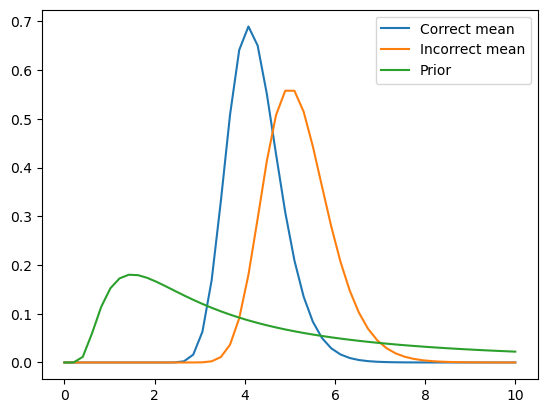

In [99]:
down_known_mu = mu_true
down_known_mu_diff = mu_true + 1
down_nu0 = 2
down_sigma2_0 = 3

true_down_posterior = known_mean_inference(X, down_nu0, down_sigma2_0, down_known_mu)
true_down_posterior_diff = known_mean_inference(X, down_nu0, down_sigma2_0, down_known_mu_diff)

xs = np.linspace(0, 10)
plt.plot(xs, true_down_posterior.pdf(xs), label="Correct mean")
plt.plot(xs, true_down_posterior_diff.pdf(xs), label="Incorrect mean")
plt.plot(xs, invchisquare(down_nu0, down_sigma2_0).pdf(xs), label="Prior")
plt.legend()
plt.show()

In [100]:
syn_known_mu = mu_true
syn_nu0 = down_nu0
syn_sigma2_0 = down_sigma2_0

syn_posterior = known_mean_inference(X, syn_nu0, syn_sigma2_0, syn_known_mu)
def sample_syn_post(size):
    mus = syn_posterior.rvs(size=size)
    return mus

In [101]:
n_syn_datasets = 400
n_syn_dataset = 20 * n
syn_sigma2_sample = sample_syn_post(n_syn_datasets)
syn_datasets = np.zeros((n_syn_datasets, n_syn_dataset))
for i in range(n_syn_datasets):
    sigma2 = syn_sigma2_sample[i]
    syn_datasets[i, :] = stats.norm.rvs(loc=syn_known_mu, scale=sigma2**0.5, size=n_syn_dataset)

syn_data_posteriors = [
    known_mean_inference(syn_datasets[i, :], down_nu0, down_sigma2_0, down_known_mu) 
    for i in range(n_syn_datasets)
]
syn_data_posteriors_diff = [
    known_mean_inference(syn_datasets[i, :], down_nu0, down_sigma2_0, down_known_mu_diff) 
    for i in range(n_syn_datasets)
]

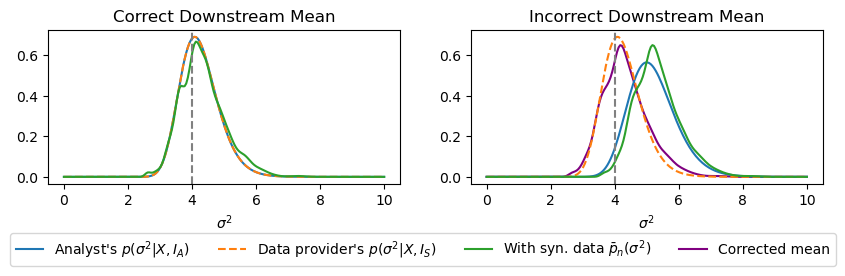

In [103]:
xs = np.linspace(0, 10, 200)

fig, axes = plt.subplots(1, 2, figsize=(10, 2))
ax = axes[0]
ax.plot(xs, true_down_posterior.pdf(xs), label=analyst_label_sigma2)
ax.plot(xs, syn_posterior.pdf(xs), label=data_provider_label_sigma2, linestyle="dashed")
ax.plot(xs, combined_posterior_pdf(xs, syn_data_posteriors), label=syn_data_label_sigma2)
ax.set_xlabel("$\sigma^2$")
ax.set_title("Correct Downstream Mean")
ax.axvline(sigma_true**2, color="grey", linestyle="dashed")

ax = axes[1]
ax.plot(xs, true_down_posterior_diff.pdf(xs), label=analyst_label_sigma2)
ax.plot(xs, syn_posterior.pdf(xs), label=data_provider_label_sigma2, linestyle="dashed")
ax.plot(xs, combined_posterior_pdf(xs, syn_data_posteriors_diff), label=syn_data_label_sigma2)
ax.plot(xs, combined_posterior_pdf(xs + (syn_known_mu - down_known_mu_diff)**2, syn_data_posteriors_diff), label="Corrected mean", zorder=-1, color="purple")
ax.set_xlabel("$\sigma^2$")
ax.set_title("Incorrect Downstream Mean")
ax.axvline(sigma_true**2, color="grey", linestyle="dashed")

leg_h, leg_l = axes[1].get_legend_handles_labels()
fig.legend(leg_h, leg_l, loc="upper center", ncol=4, bbox_to_anchor=(0.5, -0.1))
plt.savefig(figdir + "known-known-mean-results.pdf", bbox_inches="tight")
plt.show()

# Known Variance Up- and Downstream

In [104]:
down_mu_0 = 0
down_sigma_0 = 10
down_known_sigma = 1.0 * sigma_true
down_known_sigma_diff = 0.5 * sigma_true
true_down_posterior = known_variance_inference(X, down_mu_0, down_sigma_0, down_known_sigma)
true_down_posterior_diff = known_variance_inference(X, down_mu_0, down_sigma_0, down_known_sigma_diff)

In [105]:
syn_mu_0 = 0
syn_sigma_0 = 10
syn_known_sigma = 1.0 * sigma_true

syn_posterior = known_variance_inference(
    X, syn_mu_0, syn_sigma_0, syn_known_sigma
)

def sample_syn_post(size):
    mus = syn_posterior.rvs(size=size)
    return mus

In [106]:
n_syn_datasets = 400
n_syn_dataset = 20 * n
syn_mu_sample = sample_syn_post(n_syn_datasets)
syn_datasets = np.zeros((n_syn_datasets, n_syn_dataset))
for i in range(n_syn_datasets):
    mu = syn_mu_sample[i]
    syn_datasets[i, :] = stats.norm.rvs(loc=mu, scale=syn_known_sigma, size=n_syn_dataset)

syn_data_posteriors = [
    known_variance_inference(syn_datasets[i, :], down_mu_0, down_sigma_0, down_known_sigma) 
    for i in range(n_syn_datasets)
]
syn_data_posteriors_diff = [
    known_variance_inference(syn_datasets[i, :], down_mu_0, down_sigma_0, down_known_sigma_diff) 
    for i in range(n_syn_datasets)
]

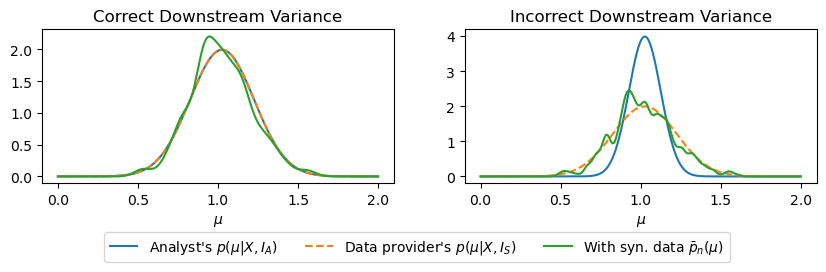

In [107]:
xs = np.linspace(0, 2, 200)

fig, axes = plt.subplots(1, 2, figsize=(10, 2))
ax = axes[0]
ax.plot(xs, true_down_posterior.pdf(xs), label=analyst_label)
ax.plot(xs, syn_posterior.pdf(xs), label=data_provider_label, linestyle="dashed")
ax.plot(xs, combined_posterior_pdf(xs, syn_data_posteriors), label=syn_data_label)
ax.set_xlabel("$\mu$")
ax.set_title("Correct Downstream Variance")

ax = axes[1]
ax.plot(xs, true_down_posterior_diff.pdf(xs), label=analyst_label)
ax.plot(xs, syn_posterior.pdf(xs), label=data_provider_label, linestyle="dashed")
ax.plot(xs, combined_posterior_pdf(xs, syn_data_posteriors_diff), label=syn_data_label)
ax.set_xlabel("$\mu$")
ax.set_title("Incorrect Downstream Variance")

leg_h, leg_l = axes[0].get_legend_handles_labels()
fig.legend(leg_h, leg_l, loc="upper center", ncol=3, bbox_to_anchor=(0.5, -0.1))
plt.savefig(figdir + "known-known-variance-results.pdf", bbox_inches="tight")
plt.show()

In [108]:
n_syn_datasets_vals = [25, 50, 100, 200, 400]
n_syn_dataset_mul_vals = [1, 2, 5, 10, 20]

def run_synthetic_data_inference(n_syn_dataset, n_syn_datasets):
    syn_mu_sample = sample_syn_post(n_syn_datasets)
    syn_datasets = np.zeros((n_syn_datasets, n_syn_dataset))
    for i in range(n_syn_datasets):
        mu = syn_mu_sample[i]
        syn_datasets[i, :] = stats.norm.rvs(loc=mu, scale=syn_known_sigma, size=n_syn_dataset)

    syn_data_posteriors = [
        known_variance_inference(syn_datasets[i, :], down_mu_0, down_sigma_0, down_known_sigma) 
        for i in range(n_syn_datasets)
    ]
    return syn_data_posteriors

syn_data_posteriors_all = {}
for i, n_syn_datasets in enumerate(n_syn_datasets_vals):
    for j, n_syn_dataset_mul in enumerate(n_syn_dataset_mul_vals):
        syn_data_posteriors_all[n_syn_datasets, n_syn_dataset_mul] = run_synthetic_data_inference(n * n_syn_dataset_mul, n_syn_datasets)

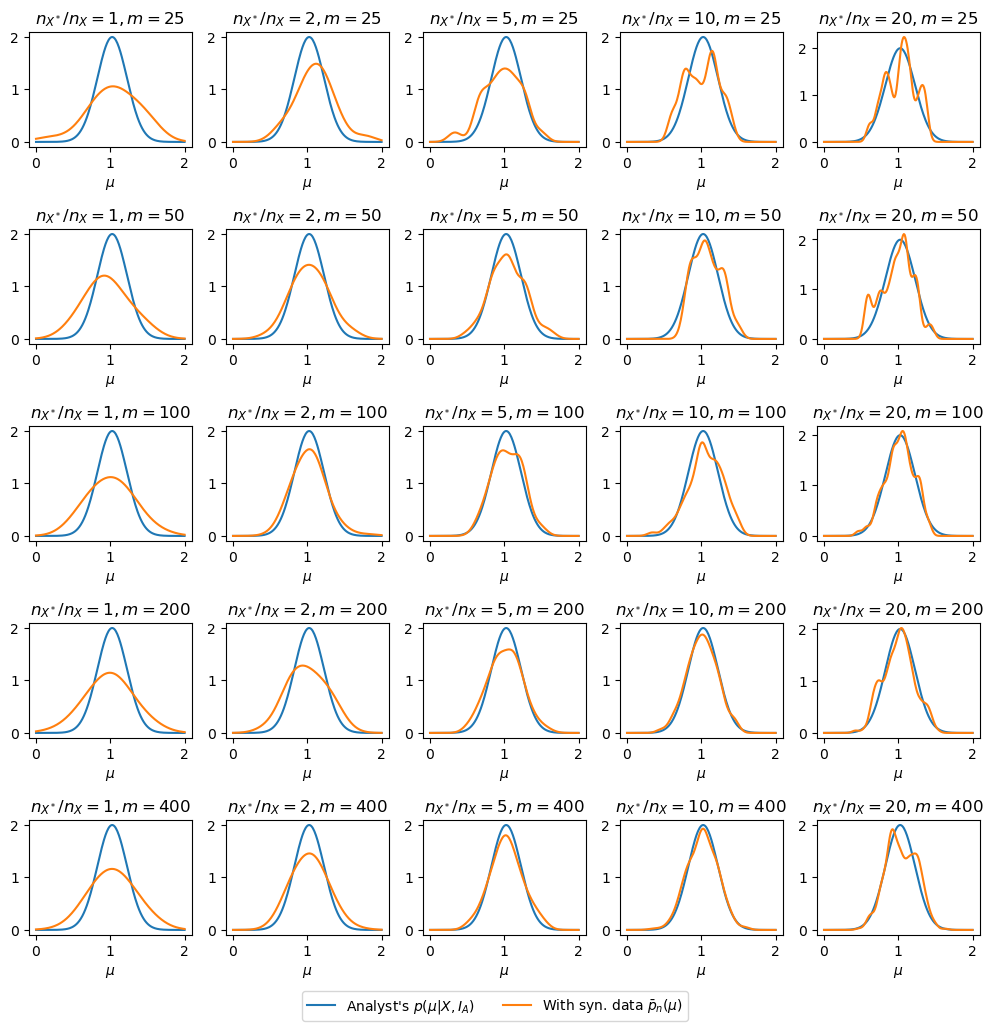

In [109]:

fig, axes = plt.subplots(
    len(n_syn_datasets_vals), len(n_syn_dataset_mul_vals), 
    figsize=(2 * len(n_syn_dataset_mul_vals), 2 * len(n_syn_datasets_vals))
)
for i, n_syn_datasets in enumerate(n_syn_datasets_vals):
    for j, n_syn_dataset_mul in enumerate(n_syn_dataset_mul_vals):
        ax = axes[i, j]
        syn_data_posteriors = syn_data_posteriors_all[n_syn_datasets, n_syn_dataset_mul]

        ax.plot(xs, true_down_posterior.pdf(xs), label=analyst_label)
        ax.plot(xs, combined_posterior_pdf(xs, syn_data_posteriors), label=syn_data_label)
        ax.set_xlabel("$\mu$")
        ax.set_title("$n_{{X^*}} / n_X = {}, m = {}$".format(n_syn_dataset_mul, n_syn_datasets))

leg_h, leg_l = axes[0, 0].get_legend_handles_labels()
fig.legend(leg_h, leg_l, loc="upper center", ncol=3, bbox_to_anchor=(0.5, 0.01))
plt.tight_layout()
plt.savefig(figdir + "known-variance-hyperparameter-results.pdf", bbox_inches="tight")
plt.show()


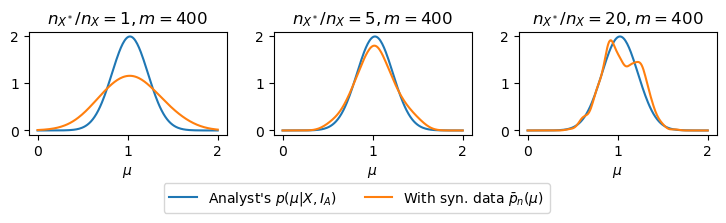

In [110]:
plot_diagonal_indices = [0, 2, 4]
fig, axes = plt.subplots(1, len(plot_diagonal_indices), figsize=(2.5 * len(plot_diagonal_indices), 2)
)
for i, ind in enumerate(plot_diagonal_indices):
    ax = axes[i]
    n_syn_datasets = n_syn_datasets_vals[-1]
    n_syn_dataset_mul = n_syn_dataset_mul_vals[ind]
    syn_data_posteriors = syn_data_posteriors_all[n_syn_datasets, n_syn_dataset_mul]

    ax.plot(xs, true_down_posterior.pdf(xs), label=analyst_label)
    ax.plot(xs, combined_posterior_pdf(xs, syn_data_posteriors), label=syn_data_label)
    ax.set_xlabel("$\mu$")
    ax.set_title("$n_{{X^*}} / n_X = {}, m = {}$".format(n_syn_dataset_mul, n_syn_datasets))

leg_h, leg_l = axes[0].get_legend_handles_labels()
fig.legend(leg_h, leg_l, loc="upper center", ncol=3, bbox_to_anchor=(0.5, 0.09))
plt.tight_layout()
plt.savefig(figdir + "known-variance-hyperparameter-results-small.pdf", bbox_inches="tight")
plt.show()

# Unknown Variance Up- and Downstream

In [111]:
down_mu_0 = 0
down_nu_0 = 2
down_sigma_0 = 1
down_kappa_0 = 2

true_sigma2_post, true_mu_post, true_mu_post_marginal = unknown_variance_inference(X, down_mu_0, down_sigma_0, down_nu_0, down_kappa_0)

In [112]:
syn_mu_0 = 0
syn_nu_0 = 2
syn_sigma_0 = 1
syn_kappa_0 = 2

syn_sigma2_post, syn_mu_post, syn_mu_post_marginal = unknown_variance_inference(
    X, syn_mu_0, syn_sigma_0, syn_nu_0, syn_kappa_0
)

def sample_syn_post(size):
    sigma2s = syn_sigma2_post.rvs(size=size)
    mus = np.zeros(size)
    mus = syn_mu_post(sigma2s).rvs(size=size)
    return mus, sigma2s

In [113]:
n_syn_datasets = 1000
n_syn_dataset = 100 * n
syn_mu_sample, syn_sigma2_sample = sample_syn_post(n_syn_datasets)
syn_datasets = np.zeros((n_syn_datasets, n_syn_dataset))
for i in range(n_syn_datasets):
    mu = syn_mu_sample[i]
    sigma2 = syn_sigma2_sample[i]
    syn_datasets[i, :] = stats.norm.rvs(loc=mu, scale=np.sqrt(sigma2), size=n_syn_dataset)

syn_data_posteriors = [
    unknown_variance_inference(syn_datasets[i, :], down_mu_0, down_sigma_0, down_nu_0, down_kappa_0)[2]
    for i in range(n_syn_datasets)
]

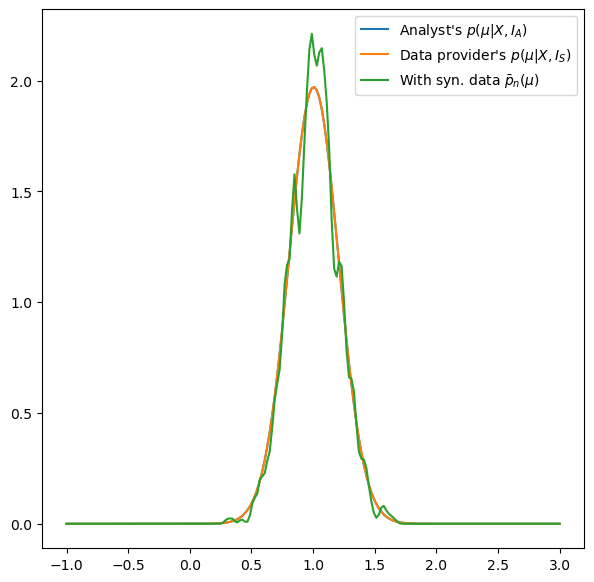

In [114]:
xs = np.linspace(-1, 3, 200)
syn_mu_sample, syn_sigma2_sample = sample_syn_post(10000)
plt.figure(figsize=(7, 7))
plt.plot(xs, true_mu_post_marginal.pdf(xs), label=analyst_label)
plt.plot(xs, syn_mu_post_marginal.pdf(xs), label=data_provider_label)
plt.plot(xs, combined_posterior_pdf(xs, syn_data_posteriors), label=syn_data_label)
plt.legend()
plt.savefig(figdir + "unknown-unknown-variance-results.pdf")
plt.show()

# Unknown Variance Upstream, Known Variance Downstream

In [115]:
down_mu_0 = 0
down_sigma_0 = 10
down_known_sigma = 1.0 * sigma_true
down_known_sigma_diff = 0.5 * sigma_true
true_down_posterior = known_variance_inference(X, down_mu_0, down_sigma_0, down_known_sigma)
true_down_posterior_diff = known_variance_inference(X, down_mu_0, down_sigma_0, down_known_sigma_diff)

In [116]:
syn_mu_0 = 0
syn_nu_0 = 2
syn_sigma_0 = 1
syn_kappa_0 = 2

syn_sigma2_post, syn_mu_post, syn_mu_post_marginal = unknown_variance_inference(
    X, syn_mu_0, syn_sigma_0, syn_nu_0, syn_kappa_0
)

def sample_syn_post(size):
    sigma2s = syn_sigma2_post.rvs(size=size)
    mus = np.zeros(size)
    mus = syn_mu_post(sigma2s).rvs(size=size)
    return mus, sigma2s

In [117]:
n_syn_datasets = 400
n_syn_dataset = 20 * n
syn_mu_sample, syn_sigma2_sample = sample_syn_post(n_syn_datasets)
syn_datasets = np.zeros((n_syn_datasets, n_syn_dataset))
for i in range(n_syn_datasets):
    mu = syn_mu_sample[i]
    sigma2 = syn_sigma2_sample[i]
    syn_datasets[i, :] = stats.norm.rvs(loc=mu, scale=np.sqrt(sigma2), size=n_syn_dataset)

syn_data_posteriors = [
    known_variance_inference(syn_datasets[i, :], down_mu_0, down_sigma_0, down_known_sigma) 
    for i in range(n_syn_datasets)
]
syn_data_posteriors_diff = [
    known_variance_inference(syn_datasets[i, :], down_mu_0, down_sigma_0, down_known_sigma_diff) 
    for i in range(n_syn_datasets)
]

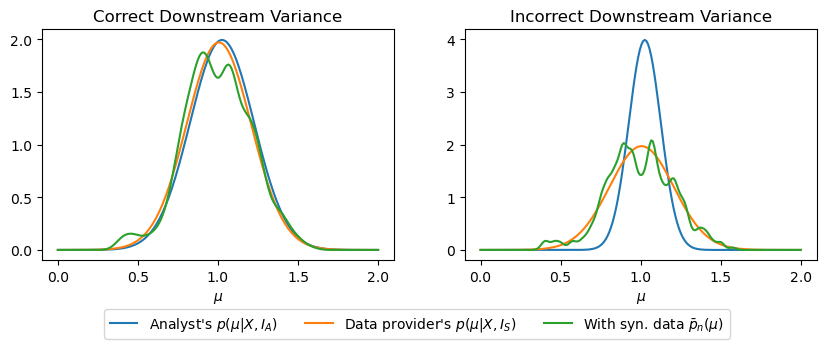

In [118]:
xs = np.linspace(0, 2, 200)

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
ax = axes[0]
ax.plot(xs, true_down_posterior.pdf(xs), label=analyst_label)
ax.plot(xs, syn_mu_post_marginal.pdf(xs), label=data_provider_label)
ax.plot(xs, combined_posterior_pdf(xs, syn_data_posteriors), label=syn_data_label)
ax.set_xlabel("$\mu$")
ax.set_title("Correct Downstream Variance")

ax = axes[1]
ax.plot(xs, true_down_posterior_diff.pdf(xs), label=analyst_label)
ax.plot(xs, syn_mu_post_marginal.pdf(xs), label=data_provider_label)
ax.plot(xs, combined_posterior_pdf(xs, syn_data_posteriors_diff), label=syn_data_label)
ax.set_xlabel("$\mu$")
ax.set_title("Incorrect Downstream Variance")

leg_h, leg_l = axes[0].get_legend_handles_labels()
fig.legend(leg_h, leg_l, loc="upper center", ncol=3, bbox_to_anchor=(0.5, -0.03))
plt.savefig(figdir + "unknown-known-variance-results.pdf", bbox_inches="tight")
plt.show()

# Known Variance Upstream, Unknown Variance Downstream

In [119]:
down_mu_0 = 0
down_nu_0 = 2
down_sigma_0 = 1
down_kappa_0 = 2

true_sigma2_post, true_mu_post, true_mu_post_marginal = unknown_variance_inference(X, down_mu_0, down_sigma_0, down_nu_0, down_kappa_0)

In [120]:
syn_mu_0 = 0
syn_sigma_0 = 10
syn_known_sigma = 1.0 * sigma_true

syn_posterior = known_variance_inference(
    X, syn_mu_0, syn_sigma_0, syn_known_sigma
)

def sample_syn_post(size):
    mus = syn_posterior.rvs(size=size)
    return mus

In [121]:
n_syn_datasets = 1000
n_syn_dataset = 100 * n
syn_mu_sample = sample_syn_post(n_syn_datasets)
syn_datasets = np.zeros((n_syn_datasets, n_syn_dataset))
for i in range(n_syn_datasets):
    mu = syn_mu_sample[i]
    syn_datasets[i, :] = stats.norm.rvs(loc=mu, scale=syn_known_sigma, size=n_syn_dataset)

syn_data_posteriors = [
    unknown_variance_inference(syn_datasets[i, :], down_mu_0, down_sigma_0, down_nu_0, down_kappa_0)[2]
    for i in range(n_syn_datasets)
]

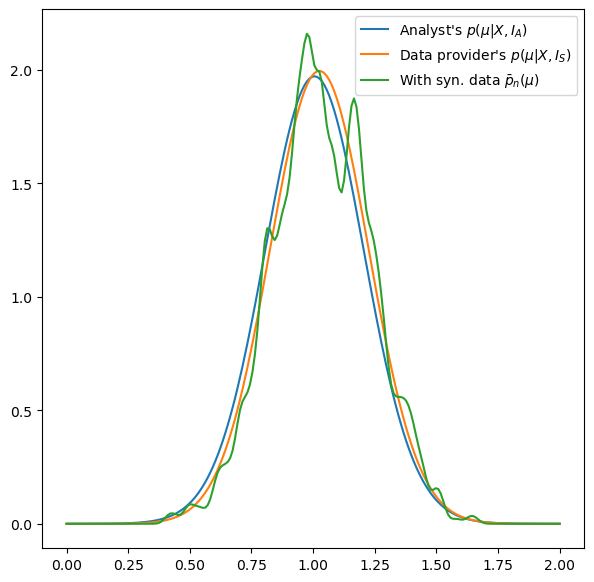

In [122]:
xs = np.linspace(-0, 2, 200)
syn_mu_sample = sample_syn_post(10000)
plt.figure(figsize=(7, 7))
plt.plot(xs, true_mu_post_marginal.pdf(xs), label=analyst_label)
plt.plot(xs, syn_posterior.pdf(xs), label=data_provider_label)
plt.plot(xs, combined_posterior_pdf(xs, syn_data_posteriors), label=syn_data_label)
plt.legend()
plt.show()

# Testing Variance Approximation Accuracy

In [123]:
def variance_correction(post_means, post_variances, n_syn, n_real):
    total_mean = post_means.mean()
    combined_var = post_means.var() + post_variances.mean()
    c = n_syn / n_real
    corrected_var = (1 + 1 / c)**(-1) * (combined_var - post_variances.mean())
    return stats.norm(loc=total_mean, scale=np.sqrt(corrected_var))

In [124]:
down_mu_0 = 0
down_sigma_0 = 10
down_known_sigma = 1.0 * sigma_true
true_down_posterior = known_variance_inference(X, down_mu_0, down_sigma_0, down_known_sigma)

## Unknown Variance Synthetic Data

In [125]:
syn_mu_0 = 0
syn_nu_0 = 2
syn_sigma_0 = 1
syn_kappa_0 = 2

syn_sigma2_post, syn_mu_post, syn_mu_post_marginal = unknown_variance_inference(
    X, syn_mu_0, syn_sigma_0, syn_nu_0, syn_kappa_0
)

def sample_syn_post(size):
    sigma2s = syn_sigma2_post.rvs(size=size)
    mus = np.zeros(size)
    mus = syn_mu_post(sigma2s).rvs(size=size)
    return mus, sigma2s

In [126]:
n_syn_datasets = 400
n_syn_dataset = 1 * n

syn_mu_sample, syn_sigma2_sample = sample_syn_post(n_syn_datasets)
syn_datasets = np.zeros((n_syn_datasets, n_syn_dataset))
for i in range(n_syn_datasets):
    mu = syn_mu_sample[i]
    sigma2 = syn_sigma2_sample[i]
    syn_datasets[i, :] = stats.norm.rvs(loc=mu, scale=np.sqrt(sigma2), size=n_syn_dataset)

syn_data_posteriors_unknown_var = [
    known_variance_inference(syn_datasets[i, :], down_mu_0, down_sigma_0, down_known_sigma) 
    for i in range(n_syn_datasets)
]

syn_data_post_means = np.array([post.mean() for post in syn_data_posteriors_unknown_var])
syn_data_post_vars = np.array([post.var() for post in syn_data_posteriors_unknown_var])
combined_approximation_unknown_var = variance_correction(syn_data_post_means, syn_data_post_vars, n_syn_dataset, n)

## Known Variance Synthetic Data

In [127]:
syn_mu_0 = 0
syn_sigma_0 = 10
syn_known_sigma = 1.0 * sigma_true

syn_posterior = known_variance_inference(
    X, syn_mu_0, syn_sigma_0, syn_known_sigma
)

def sample_syn_post(size):
    mus = syn_posterior.rvs(size=size)
    return mus

In [128]:
syn_mu_sample = sample_syn_post(n_syn_datasets)
syn_datasets = np.zeros((n_syn_datasets, n_syn_dataset))
for i in range(n_syn_datasets):
    mu = syn_mu_sample[i]
    syn_datasets[i, :] = stats.norm.rvs(loc=mu, scale=syn_known_sigma, size=n_syn_dataset)

syn_data_posteriors_known_var = [
    known_variance_inference(syn_datasets[i, :], down_mu_0, down_sigma_0, down_known_sigma) 
    for i in range(n_syn_datasets)
]

syn_data_post_means = np.array([post.mean() for post in syn_data_posteriors_known_var])
syn_data_post_vars = np.array([post.var() for post in syn_data_posteriors_known_var])
combined_approximation_known_var = variance_correction(syn_data_post_means, syn_data_post_vars, n_syn_dataset, n)

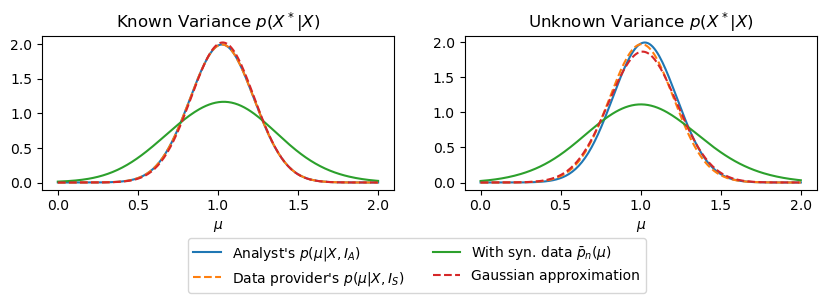

In [130]:
xs = np.linspace(0, 2, 200)

fig, axes = plt.subplots(1, 2, figsize=(10, 2))
ax = axes[0]
ax.plot(xs, true_down_posterior.pdf(xs), label=analyst_label)
ax.plot(xs, syn_posterior.pdf(xs), label=data_provider_label, linestyle="dashed")
ax.plot(xs, combined_posterior_pdf(xs, syn_data_posteriors_known_var), label=syn_data_label)
ax.plot(xs, combined_approximation_known_var.pdf(xs), label="Gaussian approximation", linestyle="dashed")
ax.set_xlabel("$\mu$")
ax.set_title("Known Variance $p(X^* | X)$")

ax = axes[1]
ax.plot(xs, true_down_posterior.pdf(xs), label=analyst_label)
ax.plot(xs, syn_mu_post_marginal.pdf(xs), label=data_provider_label, linestyle="dashed")
ax.plot(xs, combined_posterior_pdf(xs, syn_data_posteriors_unknown_var), label=syn_data_label)
ax.plot(xs, combined_approximation_unknown_var.pdf(xs), label="Gaussian approximation", linestyle="dashed")
ax.set_xlabel("$\mu$")
ax.set_title("Unknown Variance $p(X^* | X)$")

leg_h, leg_l = axes[0].get_legend_handles_labels()
fig.legend(leg_h, leg_l, loc="upper center", ncol=2, bbox_to_anchor=(0.5, -0.1))
plt.savefig(figdir + "gaussian-approximation-results.pdf", bbox_inches="tight")
plt.show()